# Financial Forecasting Model

## Steps
1. Read rows from Google BigQuery
2. Train model
3. Generate 30 day forecasts
4. Backtest
5. Insert predicted closing prices into Google BigQuery table
6. Visualize in Looker Studio

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

PROJECT_ID = os.getenv("GCP_PROJECT_ID")
TABLE_ID = "is3107-project-455413.market_data.yf_30days_json"
BIGQUERY_COLUMNS = ["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]

print(PROJECT_ID)

is3107-project-455413


In [2]:
from google.cloud import bigquery

client = bigquery.Client(PROJECT_ID)
query = f"""
SELECT Ticker, Date, Open, High, Low, Close, Volume
FROM `{TABLE_ID}`
"""

df = client.query(query).to_dataframe()

/home/muhdjabir/repo/IS3107-Group-Project/.venv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [8]:
print(df.head())
print(df.info())
print(df["Ticker"].unique())

     Ticker        Date      Open      High       Low     Close      Volume
0  DOGE-USD  2025-03-01  0.201963  0.208697  0.199463  0.206537  1197948866
1  DOGE-USD  2025-03-02  0.206537  0.241670  0.201905  0.239267  3319886568
2  DOGE-USD  2025-03-03  0.239259  0.239653  0.194282  0.199076  2824331185
3  DOGE-USD  2025-03-04  0.199082  0.201629  0.183734  0.199146  2366639397
4  DOGE-USD  2025-03-05  0.199143  0.205957  0.196583  0.204720  1433656840
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  185 non-null    object 
 1   Date    185 non-null    dbdate 
 2   Open    185 non-null    float64
 3   High    185 non-null    float64
 4   Low     185 non-null    float64
 5   Close   185 non-null    float64
 6   Volume  185 non-null    Int64  
dtypes: Int64(1), dbdate(1), float64(4), object(1)
memory usage: 10.4+ KB
None
['DOGE-USD' 'DJIA' '^NDX' '^

In [15]:
btc_df = df[df["Ticker"] == "BTC-USD"]
btc_df.set_index("Date", inplace=True)
series = btc_df["Close"]
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

best_aic = float("inf")
best_order = None
best_model = None

p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)
Z
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Optimum ARIMA order: {best_order} with AIC: {best_aic:.2f}")

Tuning ARIMA parameters...


/home/muhdjabir/repo/IS3107-Group-Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/muhdjabir/repo/IS3107-Group-Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/muhdjabir/repo/IS3107-Group-Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/muhdjabir/repo/IS3107-Group-Project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/muhdjabir/repo/IS3107-Group-Project/.v

✅ Best ARIMA order: (2, 1, 2) with AIC: 641.78


In [17]:
forecast = best_model.forecast(len(test))
forecast.index = test.index

In [18]:
import numpy as np

rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 3404.48
MAE: 2638.77


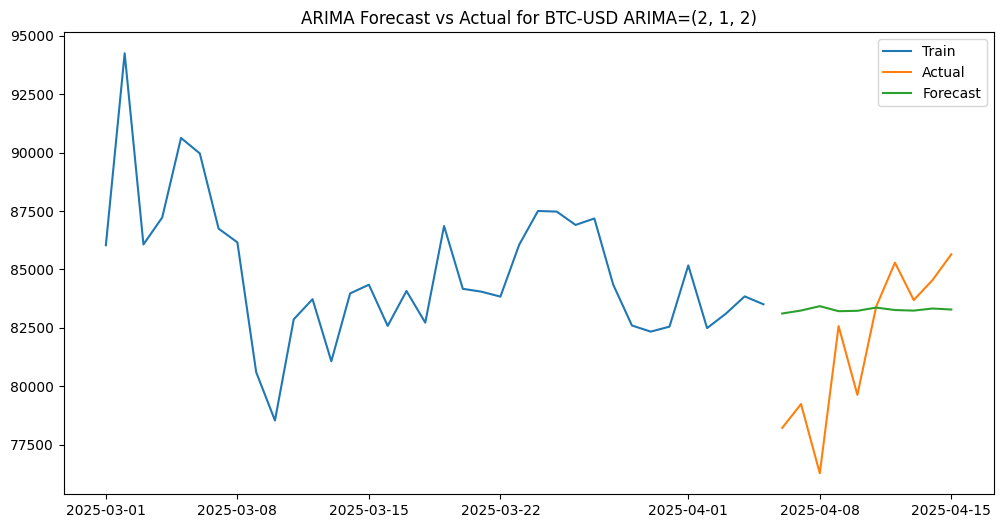

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend()
plt.title(f"ARIMA Forecast vs Actual for BTC-USD ARIMA={best_order}")
plt.show()